<a href="https://colab.research.google.com/github/JhonMales/Prediccion_aire/blob/main/redesfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

In [ ]:
# URL del endpoint para obtener datos
url = "https://api.openaq.org/v2/measurements"

# Parámetros comunes para ambas solicitudes
common_params = {
    "country": "CO",
    "date_from": "2023-08-01",
    "date_to": "2023-08-30",
    "limit": 10000,
    "page": 1,
    "offset": 0,
    "sort": "desc",
    "radius": 1000,
    "location_id": ["339555", "228248", "339556", "339558", "339557", "222263", "278598", "73539", "278596"],
    "order_by": "datetime",
}

# Parámetros para los datos de PM2.5
pm25_params = {
    "parameter": ["pm25"],
    **common_params,
}

# Parámetros para los datos de temperatura
temperature_params = {
    "parameter": ["temperature"],
    **common_params,
}

# Parámetros para los datos de humedad
humidity_params = {
    "parameter": ["humidity"],
    **common_params,
}

# Parámetros para los datos de pm10
pm10_params = {
    "parameter": ["pm10"],
    **common_params,
}

# Parámetros para los datos de pm1
pm1_params = {
    "parameter": ["pm1"],
    **common_params,
}

# Clave de API
api_key = "817602cd257d7bf84ab74352794db2b03853e01c54007b38ad346867b3724df9"

# Encabezados de la solicitud con la clave de API
headers = {
    "X-API-Key": api_key,
    "accept": "application/json",
}

# Realizar la solicitud GET para PM2.5
res_pm25 = requests.get(url, params=pm25_params, headers=headers)

# Realizar la solicitud GET para temperatura
res_temperature = requests.get(url, params=temperature_params, headers=headers)

# Realizar la solicitud GET para pm10
res_pm10 = requests.get(url, params=pm10_params, headers=headers)

# Realizar la solicitud GET para pm1
res_pm1 = requests.get(url, params=pm1_params, headers=headers)

# Realizar la solicitud GET para humedad
res_humidity = requests.get(url, params=humidity_params, headers=headers)


if res_pm25.status_code == 200 and res_temperature.status_code == 200:
    data_pm25 = res_pm25.json()
    data_temperature = res_temperature.json()
    data_pm10 = res_pm10.json()
    data_humidity = res_humidity.json()
    data_pm1 = res_pm1.json()


    # Crear DataFrames para PM2.5, temperatura, humedad, pm1 y pm10
    df_pm25 = pd.DataFrame(data_pm25["results"])
    df_temperature = pd.DataFrame(data_temperature["results"])
    df_pm10 = pd.DataFrame(data_pm10["results"])
    df_humidity = pd.DataFrame(data_humidity["results"])
    df_pm1 = pd.DataFrame(data_pm1["results"])

    # Filtrar las columnas necesarias
    df_pm25 = df_pm25[["value"]]
    df_temperature = df_temperature[["value"]]
    df_pm10 = df_pm10[["value"]]
    df_humidity = df_humidity[["value"]]
    df_pm1 = df_pm1[["value"]]

    # Renombrar columnas para indicar el parámetro
    df_pm25.rename(columns={"value": "PM2.5"}, inplace=True)
    df_pm10.rename(columns={"value": "PM10"}, inplace=True)
    df_pm1.rename(columns={"value": "PM0.1"}, inplace=True)
    df_temperature.rename(columns={"value": "Temperature"}, inplace=True)
    df_humidity.rename(columns={"value": "Humidity"}, inplace=True)

    # Combinar DataFrames en uno solo
    df_combined = pd.concat([df_pm25, df_pm10, df_pm1, df_temperature, df_humidity], axis=1)

    # Guardar el DataFrame combinado en un archivo CSV
    df_combined.to_csv('datos_combined1.csv', index=False)
else:
    print("Error en la solicitud:", res_pm25.status_code)
df_combined['PM2.5'] = round(df_combined['PM2.5'])
df_combined = df_combined[df_combined['PM2.5'] <= 200]
df_combined['PM10'] = round(df_combined['PM10'])
df_combined['PM0.1'] = round(df_combined['PM0.1'])
df_combined['Temperature'] = round((df_combined['Temperature'] - 32) * 5/9)
df_combined['Humidity'] = round(df_combined['Humidity'])

In [ ]:
df_combined

,PM2.5,PM10,PM0.1,Temperature,Humidity
0,8.0,9.0,6.0,19.0,46.0
1,6.0,7.0,4.0,25.0,31.0
2,7.0,8.0,4.0,21.0,41.0
3,7.0,7.0,2.0,20.0,45.0
4,5.0,6.0,2.0,20.0,45.0
...,...,...,...,...,...
5712,4.0,4.0,1.0,17.0,58.0
5713,5.0,6.0,3.0,18.0,48.0
5714,3.0,3.0,2.0,20.0,42.0
5715,5.0,5.0,2.0,17.0,56.0


In [ ]:
# Calcula la media de las mediciones
df_combined['PM2.5_mean'] = df_combined[['PM2.5', 'PM10', 'PM0.1']].mean(axis=1)

# Calcula la desviación estándar de las mediciones
df_combined['PM2.5_std'] = df_combined[['PM2.5', 'PM10', 'PM0.1']].std(axis=1)

In [ ]:
df_combined

,PM2.5,PM10,PM0.1,Temperature,Humidity,PM2.5_mean,PM2.5_std
0,8.0,9.0,6.0,19.0,46.0,7.666667,1.527525
1,6.0,7.0,4.0,25.0,31.0,5.666667,1.527525
2,7.0,8.0,4.0,21.0,41.0,6.333333,2.081666
3,7.0,7.0,2.0,20.0,45.0,5.333333,2.886751
4,5.0,6.0,2.0,20.0,45.0,4.333333,2.081666
...,...,...,...,...,...,...,...
5712,4.0,4.0,1.0,17.0,58.0,3.000000,1.732051
5713,5.0,6.0,3.0,18.0,48.0,4.666667,1.527525
5714,3.0,3.0,2.0,20.0,42.0,2.666667,0.577350
5715,5.0,5.0,2.0,17.0,56.0,4.000000,1.732051


from matplotlib import pyplot as plt
df_combined['PM2.5'].plot(kind='hist', bins=20, title='PM2.5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined['PM10'].plot(kind='hist', bins=20, title='PM10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined['PM0.1'].plot(kind='hist', bins=20, title='PM0.1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined.plot(kind='scatter', x='PM2.5', y='PM10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined.plot(kind='scatter', x='PM10', y='PM0.1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined.plot(kind='scatter', x='PM0.1', y='Temperature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined.plot(kind='scatter', x='Temperature', y='Humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_combined['PM2.5'].plot(kind='line', figsize=(8, 4), title='PM2.5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_combined['PM10'].plot(kind='line', figsize=(8, 4), title='PM10')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_combined['PM0.1'].plot(kind='line', figsize=(8, 4), title='PM0.1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_combined['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

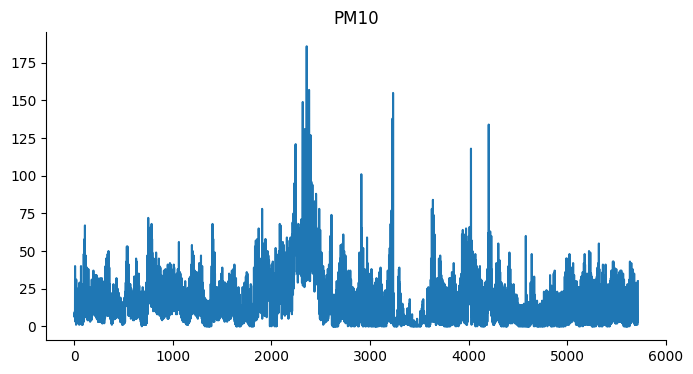

In [ ]:
from matplotlib import pyplot as plt
df_combined['PM10'].plot(kind='line', figsize=(8, 4), title='PM10')
plt.gca().spines[['top', 'right']].set_visible(False)

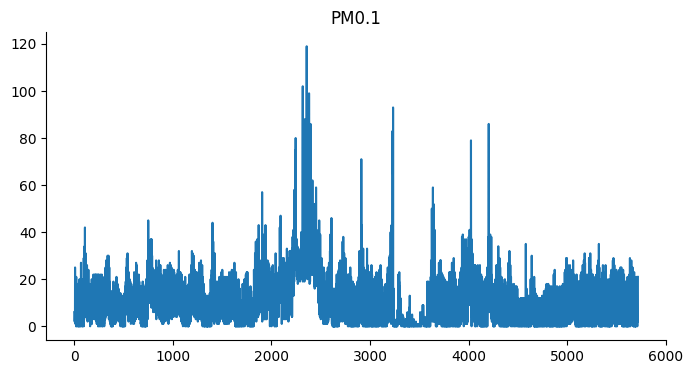

In [ ]:
from matplotlib import pyplot as plt
df_combined['PM0.1'].plot(kind='line', figsize=(8, 4), title='PM0.1')
plt.gca().spines[['top', 'right']].set_visible(False)

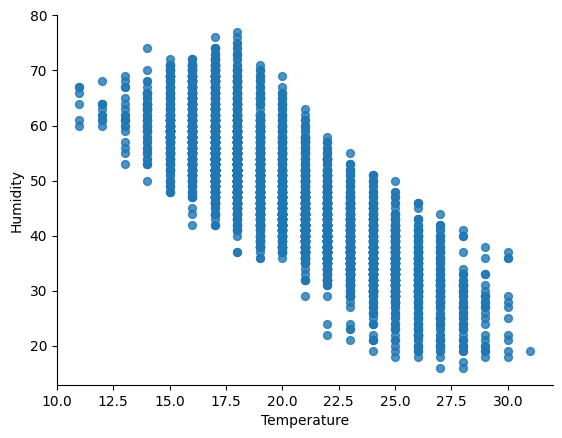

In [ ]:
from matplotlib import pyplot as plt
df_combined.plot(kind='scatter', x='Temperature', y='Humidity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

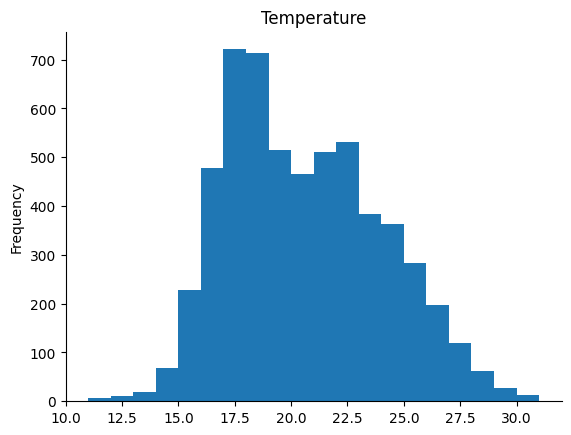

In [ ]:
from matplotlib import pyplot as plt
df_combined['Temperature'].plot(kind='hist', bins=20, title='Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

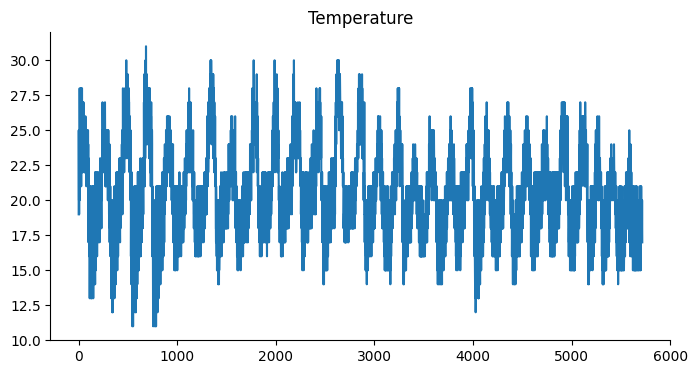

In [ ]:
from matplotlib import pyplot as plt
df_combined['Temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.gca().spines[['top', 'right']].set_visible(False)

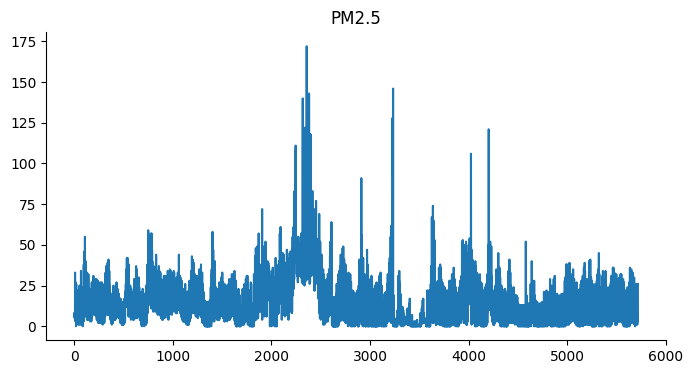

In [ ]:
from matplotlib import pyplot as plt
df_combined['PM2.5'].plot(kind='line', figsize=(8, 4), title='PM2.5')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_combined[['PM10', 'PM0.1', 'Temperature', 'Humidity']], df_combined['PM2.5_mean'], test_size=0.25)

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100)

# Evaluar el modelo
loss = model.evaluate(X_test, y_test)

# Calcular el puntaje R2
y_pred = model.predict(X_test)
r2_score = r2_score(y_test, y_pred)

# Imprimir el puntaje R2
print('R2 score:', r2_score)

Epoch 1/100
134/134 [==============================] - 1s 2ms/step - loss: 14.3360
Epoch 2/100
134/134 [==============================] - 0s 2ms/step - loss: 0.1870
Epoch 3/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0947
Epoch 4/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0765
Epoch 5/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0688
Epoch 6/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0626
Epoch 7/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 8/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0633
Epoch 9/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0652
Epoch 10/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0643
Epoch 11/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0720
Epoch 12/100
134/134 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 13/100

In [ ]:
# Imprimir la predicción [PM10	PM0.1	Temperature	Humidity]
data = np.array([[25, 17, 19, 50]])
y_pred_test = model.predict(data)
print('Predicción:', y_pred_test)

1/1 [==============================] - 0s 58ms/step
Predicción: [[21.795633]]


# **Dia siguiente**
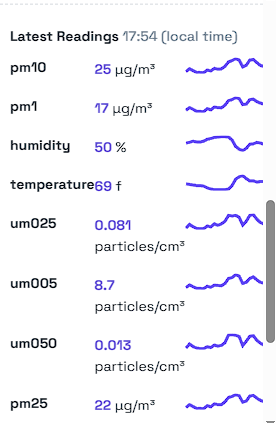

# ***Graficos***

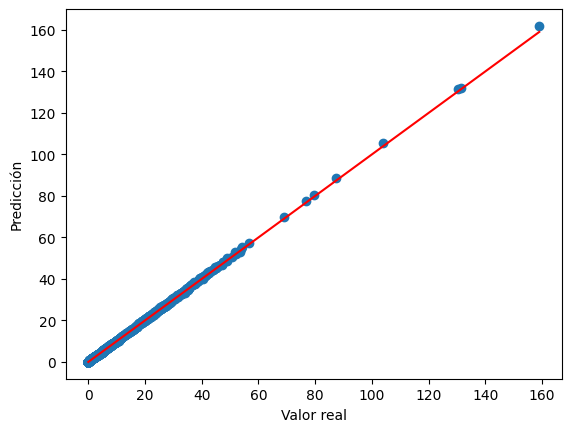

In [ ]:
# Graficar el error
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.show()

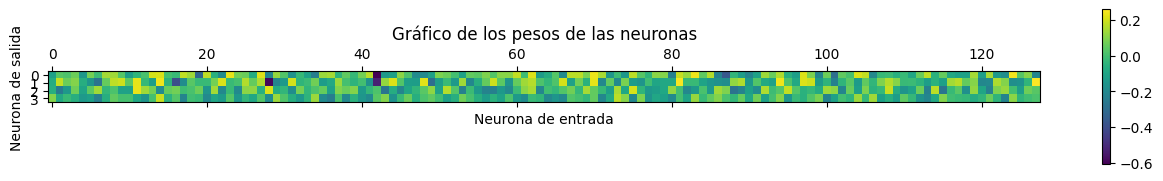

In [ ]:
# Obtener los pesos de las neuronas
weights = model.get_weights()

# Generar el gráfico de los pesos de las neuronas
plt.matshow(weights[0])
plt.xlabel('Neurona de entrada')
plt.ylabel('Neurona de salida')
plt.title('Gráfico de los pesos de las neuronas')
plt.colorbar()
plt.show()

# ***Interfaz Grafica***

In [ ]:
import tkinter as tk

def verificar_calidad_aire(valor_pm25):
    if valor_pm25 <= 12:
        return "Bueno", "green"
    elif 12 < valor_pm25 < 35:
        return "Normal", "yellow"
    elif 35 <= valor_pm25 < 55:
        return "Malo para grupos sensibles", "orange"
    elif 55 < valor_pm25 <= 150:
        return "Malo", "red"
    else:
        return "Muy malo", "purple"

def actualizar_color():
    try:
        valor_pm25 = float(entry.get())
        calidad_aire, color = verificar_calidad_aire(valor_pm25)
        ventana.config(bg=color)
        etiqueta_resultado.config(text=f"Calidad del aire: {calidad_aire}")
    except ValueError:
        etiqueta_resultado.config(text="Ingrese un valor numérico válido")

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Calidad del Aire")

# Crear widgets
etiqueta_pm25 = tk.Label(ventana, text="Valor de PM2.5:")
etiqueta_pm25.pack(pady=5)

entry = tk.Entry(ventana)
entry.pack(pady=5)

boton_actualizar = tk.Button(ventana, text="Actualizar Color", command=actualizar_color)
boton_actualizar.pack(pady=10)

etiqueta_resultado = tk.Label(ventana, text="")
etiqueta_resultado.pack(pady=5)

# Iniciar el bucle principal de la interfaz gráfica
ventana.mainloop()

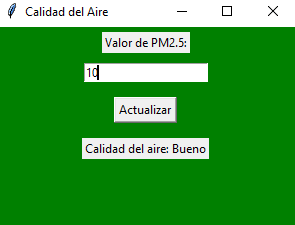
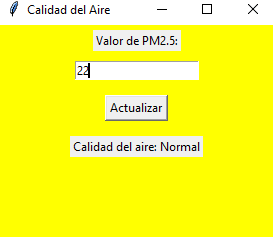
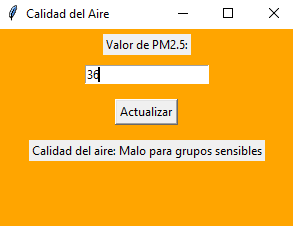
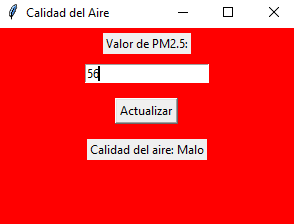
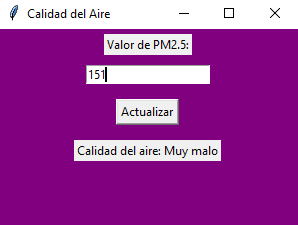